Testing SNMP GET operation:
syServices:
76

Testing SNMP SET operation:
Setting sysName to 'Network Administrator': True

Testing SNMP GETNEXT operation:
SNMPv2-MIB::sysServices.0 = 76


/var/folders/ll/bqqgfdf506s9g__v8h1jntdh0000gn/T/ipykernel_60887/2496468267.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


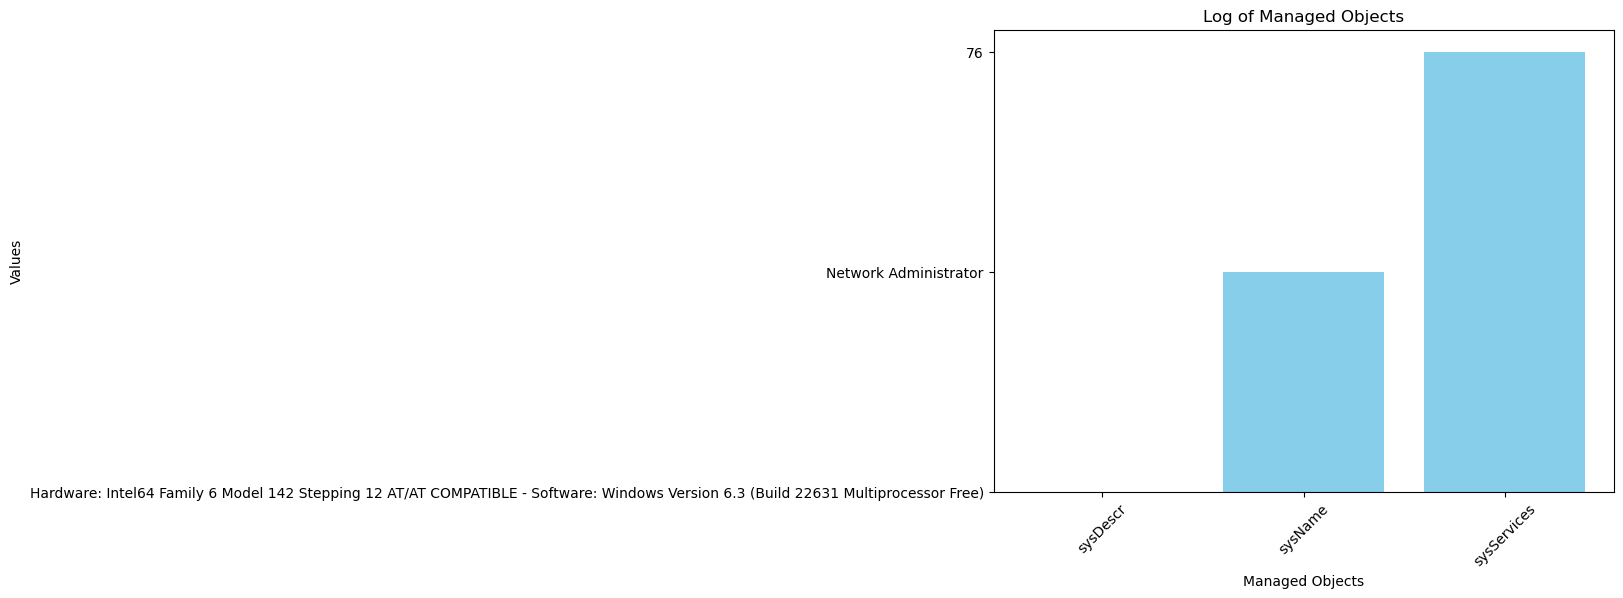

Threshold crossed! Current value (76) exceeds threshold (70)


In [6]:
from pysnmp.hlapi import *
import matplotlib.pyplot as plt

# SNMP parameters
community = 'public'
host = '172.20.10.7'
port = 161
timeout = 1
retries = 5

# get method
def snmp_get(oid):
    error_indication, error_status, error_index, var_binds = next(
        getCmd(SnmpEngine(),
               CommunityData(community),
               UdpTransportTarget((host, port), timeout=timeout, retries=retries),
               ContextData(),
               ObjectType(ObjectIdentity(oid)))
    )

    if error_indication:
        print('SNMP GET error: %s' % error_indication)
        return None
    elif error_status:
        print('SNMP GET error: %s at %s' % (
            error_status.prettyPrint(),
            error_index and var_binds[int(error_index) - 1][0] or '?'
        ))
        return None
    else:
        for varBind in var_binds:
            print(varBind[1].prettyPrint())  # Print all results

# set method
def snmp_set(oid, value, community_write='public2', data_type='str'):
    if data_type == 'str':
        value = OctetString(value)
    elif data_type == 'int':
        value = Integer(value)
    elif data_type == 'ip':
        value = IpAddress(value)
    elif data_type == 'oid':
        value = ObjectIdentifier(value)
    else:
        print('Unsupported data type')
        return

    error_indication, error_status, error_index, var_binds = next(
        setCmd(SnmpEngine(),
               CommunityData(community_write),  # Change community string here
               UdpTransportTarget((host, port), timeout=timeout, retries=retries),
               ContextData(),
               ObjectType(ObjectIdentity(oid), value))
    )

    if error_indication:
        print('SNMP SET error: %s' % error_indication)
        return False
    elif error_status:
        print('SNMP SET error: %s at %s' % (
            error_status.prettyPrint(),
            error_index and var_binds[int(error_index) - 1][0] or '?'
        ))
        return False
    else:
        return True

# get_next method
def get_next(community, host, oid):
    iterator = nextCmd(SnmpEngine(),
                       CommunityData(community),
                       UdpTransportTarget((host, 161)),
                       ContextData(),
                       ObjectType(ObjectIdentity(oid)))

    errorIndication, errorStatus, errorIndex, varBinds = next(iterator)

    if errorIndication:
        print(errorIndication)
    elif errorStatus:
        print('%s at %s' % (
            errorStatus.prettyPrint(),
            errorIndex and varBinds[int(errorIndex) - 1][0] or '?'
        ))
    else:
        for varBind in varBinds:
            print(' = '.join([x.prettyPrint() for x in varBind]))

# Threshold monitoring and action
def monitor_threshold(oid, threshold):
    error_indication, error_status, error_index, var_binds = next(
        getCmd(SnmpEngine(),
               CommunityData(community),
               UdpTransportTarget((host, port), timeout=timeout, retries=retries),
               ContextData(),
               ObjectType(ObjectIdentity(oid)))
    )

    if error_indication:
        print('SNMP GET error: %s' % error_indication)
        return
    elif error_status:
        print('SNMP GET error: %s at %s' % (
            error_status.prettyPrint(),
            error_index and var_binds[int(error_index) - 1][0] or '?'
        ))
        return
    else:
        current_value = int(var_binds[0][1])  # Assuming the value is an integer

        # Check if the threshold is crossed
        if current_value > threshold:
            # Take action based on the threshold crossing
            print(f"Threshold crossed! Current value ({current_value}) exceeds threshold ({threshold})")
            # Example action: SET a parameter on managed devices
            snmp_set('.1.3.6.1.2.1.1.5.0', 'Threshold Exceeded')
        else:
            print("Threshold not crossed.")

# Main
if __name__ == "__main__":
    # Test SNMP GET operation
    print("Testing SNMP GET operation:")
    print("syServices:")
    # OID for sysDescr
    snmp_get('1.3.6.1.2.1.1.7.0')

    # Set the sysName >> "Network Administrator"
    print("\nTesting SNMP SET operation:")
    print("Setting sysName to 'Network Administrator':", snmp_set('1.3.6.1.2.1.1.5.0', 'Network Administrator'))

    # Test SNMP GETNEXT operation
    print("\nTesting SNMP GETNEXT operation:")
    # OID for sysLocation
    get_next(community, host, '.1.3.6.1.2.1.1.6.0')

    # Log of managed objects
    log = {
        'sysDescr': 'Hardware: Intel64 Family 6 Model 142 Stepping 12 AT/AT COMPATIBLE - Software: Windows Version 6.3 (Build 22631 Multiprocessor Free)',
        'sysName': 'Network Administrator',
        'sysServices': '76'
    }

    # Plotting the log
    plt.figure(figsize=(8, 6))
    plt.bar(log.keys(), log.values(), color='skyblue')
    plt.xlabel('Managed Objects')
    plt.ylabel('Values')
    plt.title('Log of Managed Objects')
    plt.xticks(rotation=45)
    plt.tight_layout()  
    plt.show()

    # Monitor and take action based on threshold crossing
    # This is where you test the threshold
    # Change the OID and threshold value as per your requirement
    monitor_threshold('.1.3.6.1.2.1.1.7.0', 70)  # Example OID for sysDescr and threshold

